# Confidence Graphs: Representing Model Uncertainty in Deep Learning 

**Hendrik Jacob van Veen** <br>
<hendrik.vanveen@nubank.com.br> &bull; https://mlwave.com

**Matheus Facure**<br>
<matheus.facure@nubank.com.br> &bull; https://matheusfacure.github.io/

## Introduction

Variational inference [(MacKay, 2003)](http://www.inference.org.uk/mackay/itila/) gives a computationally tractible measure of uncertainty/confidence/variance for machine learning models, including complex black-box models, like those used in the fields of gradient boosting [(Chen et al, 2016)](https://dl.acm.org/citation.cfm?id=2939785) and deep learning [(Schmidhuber, 2014)](https://arxiv.org/abs/1404.7828).

The $MAPPER$ algorithm [(Singh et al, 2007)](https://research.math.osu.edu/tgda/mapperPBG.pdf) \[.pdf\] from Topological Data Analysis [(Carlsson, 2009)](http://www.ams.org/journals/bull/2009-46-02/S0273-0979-09-01249-X/) turns any data or function output into a graph (or simplicial complex) which is used for data exploration [(Lum et al, 2009)](https://www.nature.com/articles/srep01236), error analysis [(Carlsson et al, 2018)](https://arxiv.org/abs/1803.00384), serving as input for higher-level machine learning algorithms [(Hofer et al, 2017)](https://arxiv.org/abs/1707.04041), and more.

Dropout [(Srivastava et al, 2014)](http://jmlr.org/papers/v15/srivastava14a.html) can be viewed as an ensemble of many different sub-networks inside a single neural network, which, much like bootstrap aggregation of decision trees [(Breiman, 1996)](https://dl.acm.org/citation.cfm?id=231989), aims to combat overfit. Viewed as such, dropout is applicable as a Bayesian approximation [(Rubin, 1984)](https://projecteuclid.org/euclid.aos/1176346785) in the variational inference framework [(Gal, 2016)](http://www.cs.ox.ac.uk/people/yarin.gal/website/thesis/thesis.pdf) (.pdf)

Interpretability is useful for detecting bias in and debugging errors of machine learning models. Many methods exist, such as tree paths [(Saabas, 2014)](http://blog.datadive.net/interpreting-random-forests/), saliency maps, permutation feature importance [(Altmann et al, 2010)](https://academic.oup.com/bioinformatics/article/26/10/1340/193348), locally-fit white box models [(van Veen, 2015)](https://github.com/MLWave/Black-Boxxy) [(Ribeiro et al, 2016)](https://arxiv.org/abs/1602.04938). More recent efforts aim to combine a variety of methods [(Korobov et al, 2016)](https://github.com/TeamHG-Memex/eli5) [(Olah et al, 2018)](https://distill.pub/2018/building-blocks/). 

## Motivation

Error analysis surfaces different subsets/types of the data where a model makes fundamental errors. When building policies and making financial decisions based on the output of a model it is not only useful to study the errors of a model, but also the confidence:
- Correct, but low-confidence, predictions for a cluster of data tells us where to focus our active learning [(Dasgupta et al, 2009)](http://hunch.net/~active_learning/) - and data collection efforts, so as to make the model more certain. 
- Incorrect, but high-confidence predictions, surface fundamental error types that can more readily be fixed by a correction layer [(Schapire, 1999)](http://rob.schapire.net/papers/Schapire99c.pdf) \[.pdf\], or redoing feature engineering [(Guyon et al, 2006)](https://dl.acm.org/citation.cfm?id=1208773).
- Every profit-maximizing model has a prediction threshold where a decision is made [(Hardt et al, 2016)](https://arxiv.org/abs/1610.02413). However, given two equal predictions, the more confident predictions are preferred.
- Interpretability methods have focussed either on explaining the model in general, or explaining a single sample. To our knowledge, not much focus has gone in a holistic view of modeled data, including explanations for subsets of similar samples (for whatever pragmatic definition of "similar", like "similar age", "similar spend", "similar transaction behavior"). The combination of interpretability and unsupervised exploratory analysis is attractive, because it catches unexpected behavior early on, as opposed to acting on faulty model output, and digging down to find a cause.


## Experimental setup

We will use the MNIST dataset [(LeCun et al, 1999)](http://yann.lecun.com/exdb/mnist/), Keras [(Chollet et al, 2015)](https://keras.io/) with TensorFlow [(Abadi et al, 2016)](https://arxiv.org/abs/1603.04467), NumPy [(van der Walt et al., 2011)](https://arxiv.org/abs/1102.1523), Pandas [(McKinney, 2010)](http://conference.scipy.org/proceedings/scipy2010/mckinney.html), Scikit-Learn [(Pedregosa et al, 2011)](http://scikit-learn.org/), Matplotlib [(Hunter, 2007)](https://matplotlib.org/), and KeplerMapper  [(Saul et al, 2017)](https://github.com/MLWave/kepler-mapper).

- To classify between the digits 3 and 5, we will train a Multi-Layer Perceptron [(Ivakhnenko et al, 1965)](http://www.worldcat.org/title/cybernetic-predicting-devices/oclc/23815433) with 2 hidden layers, Backprop [(LeCun et al, 1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf) (pdf), RELU activation [(Nair et al, 2010)](https://dl.acm.org/citation.cfm?id=3104425), ADAM optimizer [(Kingma et al, 2014)](https://arxiv.org/abs/1412.6980), dropout of 0.5, and softmax output, to classify between the digits 3 and 5.

- We perform a 1000 forward passes to get the standard deviation and variance ratio of our predictions as per [(Gal, 2016, page 51)](http://www.cs.ox.ac.uk/people/yarin.gal/website/thesis/thesis.pdf) [.pdf].

- Closely following the $FiFa$ method from [(Carlsson et al, 2018, page 4)](https://arxiv.org/abs/1803.00384) we then apply $MAPPER$ with the 2D filter function `[predicted probability(x), confidence(x)]` to project the data. We cover this projection with 10 10% overlapping intervals per dimension. We cluster with complete single-linkage agglomerative clustering (`n_clusters=3`) [(Ward, 1963)](https://www.jstor.org/stable/2282967) and use the penultimate layer as the inverse $X$. To guide exploration, we color the graph nodes by `mean absolute error(x)`.

- We also ask predictions for the digit 4 which was never seen during training [(Larochelle et al, 2008)](https://dl.acm.org/citation.cfm?id=1620172), to see how this influences the confidence of the network, and to compare the graphs outputted by KeplerMapper.

- For every graph node we show the original images. Binary classification on MNIST digits is easy enough to resort to a simple interpretability method to show what distinguishes the cluster from the rest of the data: We order each feature by z-score and highlight the top 10% features [(Singh, 2016)](https://www.ayasdi.com/blog/bigdata/5191-2/).

In [1]:
%matplotlib inline

import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

import kmapper as km
import numpy as np
import pandas as pd
from sklearn import metrics, cluster, preprocessing
import xgboost as xgb

from matplotlib import pyplot as plt
plt.style.use("ggplot")

Using TensorFlow backend.


## Preparing Data

We create train and test data sets for the digits 3, 4, and 5.

In [2]:
# get the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_strange = X_train[y_train == 4]
y_strange = y_train[y_train == 4]

X_train = X_train[np.logical_or(y_train == 3, y_train == 5)]
y_train = y_train[np.logical_or(y_train == 3, y_train == 5)]

X_test = X_test[np.logical_or(y_test == 3, y_test == 5)]
y_test = y_test[np.logical_or(y_test == 3, y_test == 5)]

X_strange = X_strange[:X_test.shape[0]]
y_strange = y_strange[:X_test.shape[0]]

X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_strange = X_strange.reshape(-1, 784)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_strange = X_strange.astype('float32')

X_train /= 255
X_test /= 255
X_strange /= 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_strange.shape[0], 'strange samples')

# convert class vectors to binary class matrices
y_train = (y_train == 3).astype(int)
y_test = (y_test == 3).astype(int)

y_mean_test = y_test.mean()
print(y_mean_test, 'y test mean')

11552 train samples
1902 test samples
1902 strange samples
0.5310199789695058 y test mean


## Model
Model is a basic 2-hidden layer MLP with RELU activation, ADAM optimizer, and softmax output. Dropout is applied to every layer but the final.

In [3]:
batch_size = 128
num_classes = 1
epochs = 10

model = Sequential()
model.add(Dropout(0.5, input_shape=(784,)))
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 665,089
Trainable params: 665,089
Non-trainable params: 0
_________________________________________________________________


## Fitting and evaluation

In [4]:
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
score

Train on 11552 samples, validate on 1902 samples
Epoch 1/10
11552/11552 [==============================] - 3s 217us/step - loss: 0.2627 - acc: 0.8872 - val_loss: 0.0800 - val_acc: 0.9679
Epoch 2/10
11552/11552 [==============================] - 2s 161us/step - loss: 0.1389 - acc: 0.9459 - val_loss: 0.0650 - val_acc: 0.9742
Epoch 3/10
11552/11552 [==============================] - 1s 128us/step - loss: 0.1092 - acc: 0.9592 - val_loss: 0.0417 - val_acc: 0.9879
Epoch 4/10
11552/11552 [==============================] - 1s 120us/step - loss: 0.0936 - acc: 0.9657 - val_loss: 0.0388 - val_acc: 0.9869
Epoch 5/10
11552/11552 [==============================] - 1s 117us/step - loss: 0.0800 - acc: 0.9681 - val_loss: 0.0325 - val_acc: 0.9921
Epoch 6/10
11552/11552 [==============================] - 1s 115us/step - loss: 0.0730 - acc: 0.9735 - val_loss: 0.0291 - val_acc: 0.9916
Epoch 7/10
11552/11552 [==============================] - 1s 113us/step - loss: 0.0685 - acc: 0.9760 - val_loss: 0.0284 - v

[0.027948900684616387, 0.9931650893796005]

## Perform 1000 forward passes on test set and calculate Variance Ratio and Standard Dev

In [5]:
FP = 1000
predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

y_pred_test = np.array([predict_stochastic([X_test, 1]) for _ in range(FP)])
y_pred_stochastic_test = y_pred_test.reshape(-1,y_test.shape[0]).T

y_pred_std_test = np.std(y_pred_stochastic_test, axis=1)
y_pred_mean_test = np.mean(y_pred_stochastic_test, axis=1)
y_pred_mode_test = (np.mean(y_pred_stochastic_test > .5, axis=1) > .5).astype(int).reshape(-1,1)

y_pred_var_ratio_test = 1 - np.mean((y_pred_stochastic_test > .5) == y_pred_mode_test, axis=1)

test_analysis = pd.DataFrame({
    "y_true": y_test,
    "y_pred": y_pred_mean_test,
    "VR": y_pred_var_ratio_test,
    "STD": y_pred_std_test
})

print(metrics.accuracy_score(y_true=y_test, y_pred=y_pred_mean_test > .5))
print(test_analysis.describe())

0.9905362776025236
            y_true       y_pred           VR          STD
count  1902.000000  1902.000000  1902.000000  1902.000000
mean      0.531020     0.544015     0.021121     0.053761
std       0.499168     0.471939     0.067162     0.077280
min       0.000000     0.000001     0.000000     0.000010
25%       0.000000     0.006608     0.000000     0.004060
50%       1.000000     0.911458     0.000000     0.020484
75%       1.000000     0.998069     0.005000     0.064760
max       1.000000     0.999999     0.500000     0.367364


## Plot test set confidence

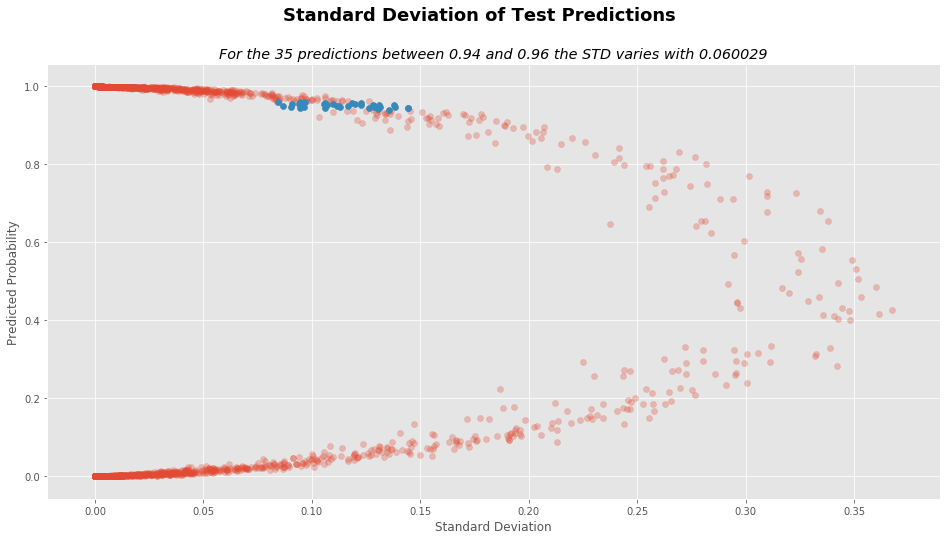

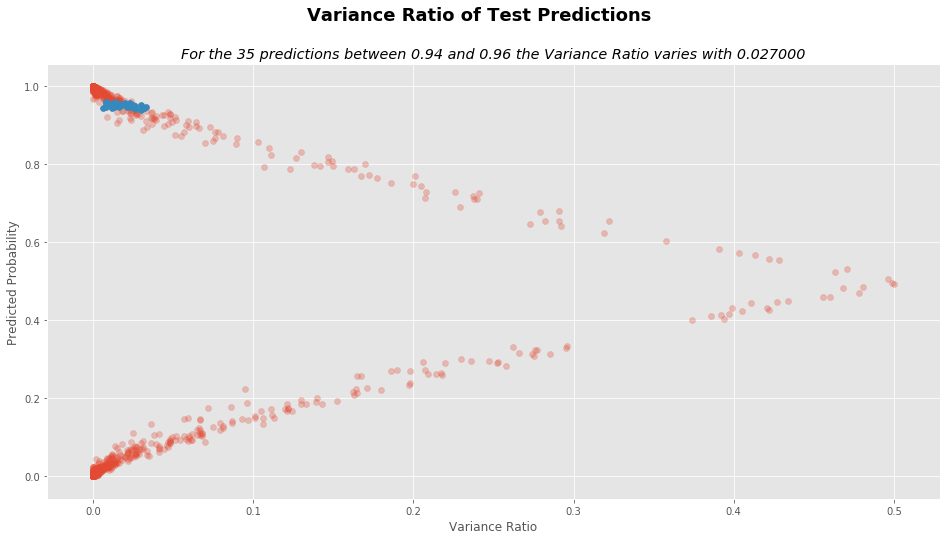

In [6]:
prediction_cut_off = (test_analysis.y_pred < .96) & (test_analysis.y_pred > .94)
std_diff = test_analysis.STD[prediction_cut_off].max() - test_analysis.STD[prediction_cut_off].min() 
vr_diff = test_analysis.VR[prediction_cut_off].max() - test_analysis.VR[prediction_cut_off].min() 
num_preds = test_analysis.STD[prediction_cut_off].shape[0]

# STD plot
plt.figure(figsize=(16,8))
plt.suptitle("Standard Deviation of Test Predictions", fontsize=18, weight="bold")
plt.title("For the %d predictions between 0.94 and 0.96 the STD varies with %f"%(num_preds, std_diff),
         style="italic")
plt.xlabel("Standard Deviation")
plt.ylabel("Predicted Probability")
plt.scatter(test_analysis.STD, test_analysis.y_pred, alpha=.3)
plt.scatter(test_analysis.STD[prediction_cut_off],
            test_analysis.y_pred[prediction_cut_off])
plt.show()

# VR plot
plt.figure(figsize=(16,8))
plt.suptitle("Variance Ratio of Test Predictions", fontsize=18, weight="bold")
plt.title("For the %d predictions between 0.94 and 0.96 the Variance Ratio varies with %f"%(num_preds, vr_diff),
         style="italic")
plt.xlabel("Variance Ratio")
plt.ylabel("Predicted Probability")
plt.scatter(test_analysis.VR, test_analysis.y_pred, alpha=.3)
plt.scatter(test_analysis.VR[prediction_cut_off],
            test_analysis.y_pred[prediction_cut_off])
plt.show()

## Apply $MAPPER$

### Take penultimate layer activations from test set for the inverse $X$

In [7]:
predict_penultimate_layer =  K.function([model.layers[0].input, K.learning_phase()], [model.layers[-2].output])

X_inverse_test = np.array(predict_penultimate_layer([X_test, 1]))[0]
print((X_inverse_test.shape, "X_inverse_test shape"))

((1902, 512), 'X_inverse_test shape')


### Take STD and error as the projected $X$

In [8]:
X_projected_test = np.c_[test_analysis.STD, test_analysis.y_true - test_analysis.y_pred]
print((X_projected_test.shape, "X_projected_test shape"))

((1902, 2), 'X_projected_test shape')


### Create the confidence graph $G$

In [9]:
mapper = km.KeplerMapper(verbose=2)
G = mapper.map(X_projected_test,
               X_inverse_test,
               clusterer=cluster.AgglomerativeClustering(n_clusters=2),
               overlap_perc=0.8,
               nr_cubes=10)

KeplerMapper()
Mapping on data shaped (1902, 512) using lens shaped (1902, 2)

Minimal points in hypercube before clustering: 2
Creating 100 hypercubes.
There are 0 points in cube_0 / 100
Cube_0 is empty.

There are 0 points in cube_1 / 100
Cube_1 is empty.

There are 0 points in cube_2 / 100
Cube_2 is empty.

There are 0 points in cube_3 / 100
Cube_3 is empty.

There are 0 points in cube_4 / 100
Cube_4 is empty.

There are 1437 points in cube_5 / 100
Found 2 clusters in cube_5

There are 1437 points in cube_6 / 100
Found 2 clusters in cube_6

There are 0 points in cube_7 / 100
Cube_7 is empty.

There are 0 points in cube_8 / 100
Cube_8 is empty.

There are 0 points in cube_9 / 100
Cube_9 is empty.

There are 1 points in cube_10 / 100
Cube_10 is empty.

There are 0 points in cube_11 / 100
Cube_11 is empty.

There are 0 points in cube_12 / 100
Cube_12 is empty.

There are 0 points in cube_13 / 100
Cube_13 is empty.

There are 0 points in cube_14 / 100
Cube_14 is empty.

There are 382 po

### Create color function output (absolute error)

In [10]:
color_function_output = np.sqrt((y_test-test_analysis.y_pred)**2)

### Create image tooltips for samples that are interpretable for humans

In [11]:
import io
import base64
from scipy.misc import toimage, imsave, imresize

# Create z-scores
hard_predictions = (test_analysis.y_pred > 0.5).astype(int)

o = np.std(X_test, axis=0)
u = np.mean(X_test[hard_predictions == 0], axis=0)
v = np.mean(X_test[hard_predictions == 1], axis=0)
z_scores = (u-v)/o

scores_0 = sorted([(score,i) for i, score in enumerate(z_scores) if str(score) != "nan"],
               reverse=False)
scores_1 = sorted([(score,i) for i, score in enumerate(z_scores) if str(score) != "nan"],
               reverse=True)

# Fill RGBA image array with top 200 scores for positive and negative
img_array_0 = np.zeros((28,28,4))
img_array_1 = np.zeros((28,28,4))

for e, (score, i) in enumerate(scores_0[:200]):
    y = i % 28
    x = int((i - (i % 28))/28)
    img_array_0[x][y] = [255,255,0,205-e]
    
for e, (score, i) in enumerate(scores_1[:200]):
    y = i % 28
    x = int((i - (i % 28))/28)
    img_array_1[x][y] = [255,0,0,205-e]

img_array = (img_array_0 + img_array_1) / 2

# Get base64 encoded version of this
output = io.BytesIO()
img = imresize(img_array, (64,64))
img = toimage(img)

img.save(output, format="PNG")
contents = output.getvalue()
explanation_img_encoded = base64.b64encode(contents)    
output.close()

# Create tooltips for each digit
tooltip_s = []
for ys, image_data in zip(y_test, X_test):
    output = io.BytesIO()
    img = toimage(imresize(image_data.reshape((28,28)), (64,64))) # Data was a flat row of "pixels".
    img.save(output, format="PNG")
    contents = output.getvalue()
    img_encoded = base64.b64encode(contents)
    img_tag =  """<div style="width:71px;
                             height:71px;
                             overflow:hidden;
                             float:left;
                             position: relative;">
                 <img src="data:image/png;base64,%s" style="position:absolute; top:0; right:0" />
                 <img src="data:image/png;base64,%s" style="position:absolute; top:0; right:0;
                                                            opacity:0.5; width: 64px; height: 64px;" />
                 <div style="position: relative; top: 0; left: 1px; font-size:9px">%s</div>
                 </div>"""%((img_encoded.decode('utf-8'),
                             explanation_img_encoded.decode('utf-8'),
                             ys))
    
    tooltip_s.append(img_tag)
    output.close()
tooltip_s = np.array(tooltip_s)

/Users/sauln/libraries/kepler-mapper/venv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/sauln/libraries/kepler-mapper/venv/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/Users/sauln/libraries/kepler-mapper/venv/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/Users/sauln/libraries/kepler-mapper/venv/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/Users/sauln/libr

### Visualize

In [12]:
_ = mapper.visualize(G,
                     lens=X_projected_test,
                     lens_names=["Uncertainty", "Error"],
                     custom_tooltips=tooltip_s,
                     color_values=color_function_output.values,
                     title="Confidence Graph for a MLP trained on MNIST",
                     path_html="confidence_graph_output.html")

Wrote visualization to: confidence_graph_output.html


In [13]:
from kmapper import jupyter
jupyter.display("confidence_graph_output.html")

## Image of output
![img](https://i.imgur.com/EycZWRR.png)
## Link to output
http://mlwave.github.io/tda/confidence-graphs.html